# **2023-2 비지니스머신러닝이론및실습**

Takehome exam (due date : 12월 21일까지)

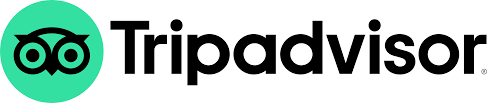

첨부된 파일은 로마시내의 호텔 목록이다. Tripadvisor를 통해 투숙객이 부여할 평점을 예측해 보시오. 또한 결과를 분석하여 나름의 business insight를 도출해 보시오.
- 결과의 재현을 위해 random_state는 123으로 고정한다.
- 각 feature의 사용 유무/feature engineering은 적절히 판단한다.
- test 데이터는 전체 데이터의 20%를 사용하여 평가한다.
- 아래 코드는 가이드 코드이므로 제출할 때에는 계산된 결과보다 정확한 결과가 도출되도록 노력한다.

이 과제는 Takehome exam이므로 **혼자서 프로젝트를 진행해야 한다**.
(아는 사람과 공유하면 그것 때문에 본인의 성적이 떨어질 수 있다.)

# 코드


## Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/HUFS 23-2/Business Machine Learning/data

/content/drive/MyDrive/HUFS 23-2/Business Machine Learning/data


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
data = pd.read_csv('final_project_hotelReview.csv',encoding='CP949')
data.head()

,Unnamed: 0,hotel_url,name,bubble_rating,category_hotel,category_inn,category_specialty,class,n_reviews,location_grade,...,amenities_Wardrobe / closet,amenities_Washing machine,amenities_Water park,amenities_Water park offsite,amenities_Waterslide,amenities_Waxing services,amenities_Whirlpool bathtub,amenities_Wifi,amenities_Wine / champagne,amenities_Yoga classes
0,1,https://www.tripadvisor.com/Hotel_Review-g1877...,Casa Mia in Trastevere,4.5,0,1,0,3,154,100.0,...,0,0,0,0,0,0,0,1,1,0
1,2,https://www.tripadvisor.com/Hotel_Review-g1877...,Hotel Artemide,5.0,1,0,0,4,8286,100.0,...,1,1,0,0,0,0,0,1,0,0
2,3,https://www.tripadvisor.com/Hotel_Review-g1877...,A.Roma Lifestyle Hotel,4.5,1,0,0,4,4389,51.0,...,0,0,0,0,0,0,0,1,0,0
3,4,https://www.tripadvisor.com/Hotel_Review-g1877...,iQ Hotel Roma,4.5,1,0,0,4,4987,100.0,...,1,1,0,0,0,0,0,1,1,0
4,5,https://www.tripadvisor.com/Hotel_Review-g1877...,The Guardian,4.5,1,0,0,3,1068,100.0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
print(data.shape)

(4599, 267)


In [ ]:
data.drop(['Unnamed: 0', 'hotel_url', 'name'], axis=1, inplace=True)

In [ ]:
# 호텔 등급 없는 것들은 모두 0으로 변환
idx = data['class'] == 'no stars'
data.loc[idx, 'class'] = 0

# missing value 포함한 feature 정보 출력
for i in data.columns:
    if data[i].isnull().sum() > 0:
        print(i, data[i].isnull().sum())

location_grade 218
price_curr_min 2224
price_min 1125
price_max 1127
photos 577


## Data pre-processing


### 결측치 처리: SimpleImputer

In [ ]:
from sklearn.impute import SimpleImputer

# 결측치가 있는 행과 없는 행 분리
missing_rows = data[data.isnull().any(axis=1)]
not_missing_rows = data.dropna()

# SimpleImputer 초기화 (평균값 사용)
imputer = SimpleImputer(strategy='mean')

# 'class' 열에서 'no stars'를 0으로 변환
idx = data['class'] == 'no stars'
data.loc[idx, 'class'] = 0

# Feature와 Target 변수 정의
X = data.drop('bubble_rating', axis=1)
y = data['bubble_rating']

# SimpleImputer를 사용하여 결측치 채우기
data_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# 결측치를 채운 데이터에 target 변수 추가
data_imputed['bubble_rating'] = y

In [ ]:
# 확인
for i in data_imputed.columns:
    if data_imputed[i].isnull().sum() > 0:
        print(i, data[i].isnull().sum())

## lightgbm - no PCA ver.


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Feature와 Target 변수 정의
X_imputed = data_imputed.drop('bubble_rating', axis=1)
y_imputed = data_imputed['bubble_rating']

# 특수 문자가 포함된 칼럼 이름에서 특수 문자 제거
X_imputed.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_imputed.columns]

# 데이터를 훈련 세트와 테스트 세트로 나눔
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=123)

# 실험할 하이퍼파라미터 조합 설정
learning_rates = [0.01, 0.05, 0.1, 0.2]
max_depths = [3, 5, 7, 9]

# 모든 조합에 대해 성능을 저장할 딕셔너리
results = {}

# 각 조합에 대해 모델 훈련 및 성능 측정
for lr in learning_rates:
    for depth in max_depths:
        # LightGBM 모델 초기화 및 학습
        lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=lr, max_depth=depth, random_state=123)
        lgb_model.fit(X_train, y_train)

        # 훈련 세트와 테스트 세트에 대한 예측
        y_train_pred = lgb_model.predict(X_train)
        y_test_pred = lgb_model.predict(X_test)

        # RMSE 계산
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

        # R2 score 계산
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)

        # 결과 저장
        results[(lr, depth)] = {'rmse_train': rmse_train, 'rmse_test': rmse_test, 'r2_train': r2_train, 'r2_test': r2_test}

# 결과 출력
for params, metrics in results.items():
    print(f"Learning Rate: {params[0]}, Max Depth: {params[1]}")
    print(f"RMSE Train: {metrics['rmse_train']}")
    print(f"RMSE Test: {metrics['rmse_test']}")
    print(f"R2 Score Train: {metrics['r2_train']}")
    print(f"R2 Score Test: {metrics['r2_test']}")
    print("-" * 30)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 3679, number of used features: 175
[LightGBM] [Info] Start training from score 4.065643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

## L1L2 규제

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Learning Rate와 Max Depth 설정
learning_rate = 0.05
max_depth = 3

# 규제 매개변수 값 설정
reg_alpha_values = [0, 0.1, 0.5]
reg_lambda_values = [0, 0.1, 0.5]

# 결과 저장을 위한 딕셔너리
results = {}

# 피처 중요도 저장을 위한 딕셔너리
feature_importance_results = {}

# 조합에 대한 반복문
for reg_alpha in reg_alpha_values:
    for reg_lambda in reg_lambda_values:
        # LightGBM 모델 초기화 및 학습
        lgb_model = lgb.LGBMRegressor(
            n_estimators=100,
            learning_rate=learning_rate,
            max_depth=max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            random_state=123
        )
        lgb_model.fit(X_train, y_train)

        # 훈련 세트와 테스트 세트에 대한 예측
        y_train_pred = lgb_model.predict(X_train)
        y_test_pred = lgb_model.predict(X_test)

        # RMSE 계산
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

        # R-squared score 계산
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)

        # 결과 저장
        key = f"Reg Alpha: {reg_alpha}, Reg Lambda: {reg_lambda}"
        results[key] = {"RMSE Train": rmse_train, "RMSE Test": rmse_test, "R2 Train": r2_train, "R2 Test": r2_test}

        # 피처 중요도 저장
        feature_importance_results[key] = {"Feature Importance": lgb_model.feature_importances_}

# 결과 및 피처 중요도 출력
for key, result in results.items():
    print(key)
    print(f"RMSE Train: {result['RMSE Train']}")
    print(f"RMSE Test: {result['RMSE Test']}")
    print(f"R2 Train: {result['R2 Train']}")
    print(f"R2 Test: {result['R2 Test']}")
    print("------------------------------")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 3679, number of used features: 175
[LightGBM] [Info] Start training from score 4.065643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 3679, number of used features: 175
[LightGBM] [Info] Start training from score 4.065643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

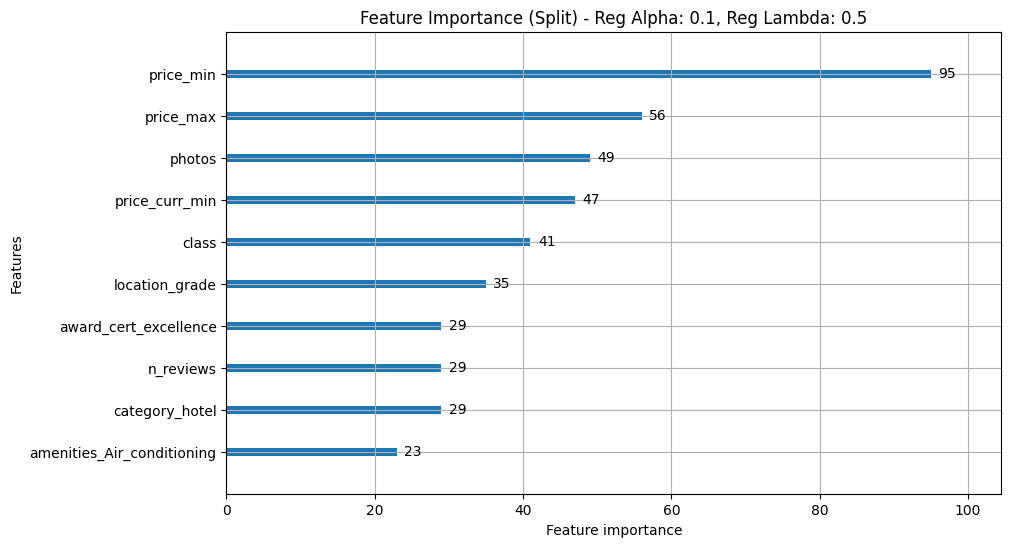

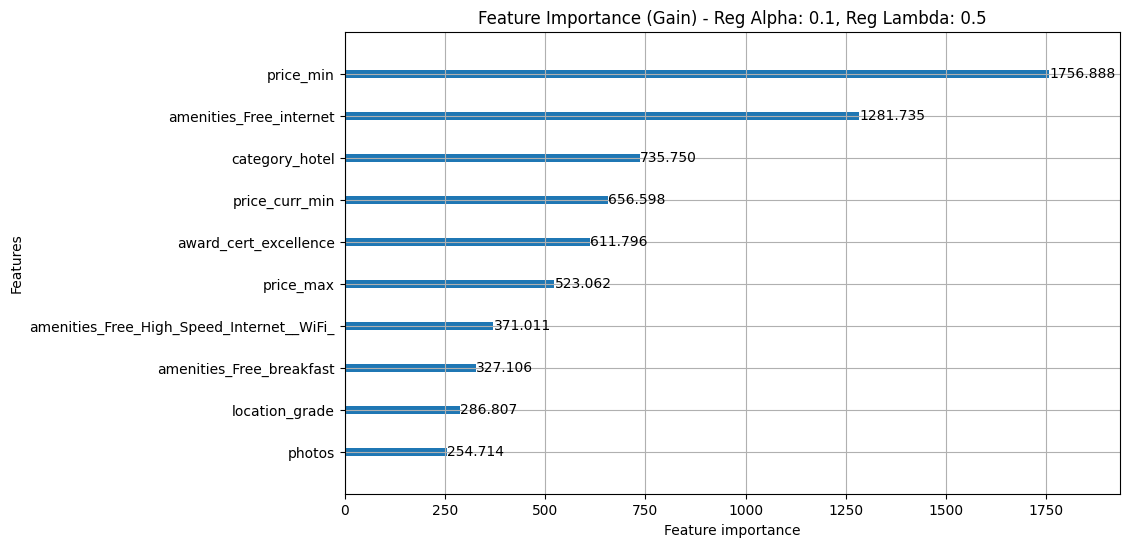

In [ ]:
import matplotlib.pyplot as plt

# LightGBM 모델 초기화 및 학습
lgb_model_selected = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    reg_alpha=0.1,
    reg_lambda=0.5,
    random_state=123
)
lgb_model_selected.fit(X_train, y_train)

# 피처 중요도 시각화
lgb.plot_importance(lgb_model_selected, max_num_features=10, importance_type='split', figsize=(10, 6))
plt.title("Feature Importance (Split) - Reg Alpha: 0.1, Reg Lambda: 0.5")
plt.show()

lgb.plot_importance(lgb_model_selected, max_num_features=10, importance_type='gain', figsize=(10, 6))
plt.title("Feature Importance (Gain) - Reg Alpha: 0.1, Reg Lambda: 0.5")
plt.show()
